# Why hybrid method is better

### what I use:

- Dataset : AWA2
    - Class : 18 Class
    - Image per Class : 48
    - Path : C:\ProjectWork\Basic_Python\Zero_shot_Learning\Dataset\artefact1\test
        
- Dataset : AWA2
    - Class : 8 Class
    - Image per Class : 21
    - Path : C:\ProjectWork\Basic_Python\Zero_shot_Learning\Dataset\artefact1\test_sun


### Step 1: Why and How 40 to 18 logic (Sementic similarity)

...

path test AWA2 = C:\ProjectWork\Basic_Python\Zero_shot_Learning\Dataset\artefact1\test

In [1]:
# lib's
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import shutil

import csv
from sklearn.cluster import KMeans
from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import img_to_array  # Updated import
from keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# display all the columns of the dataframes
pd.pandas.set_option('display.max_columns', None)

### Step 2: Feture extraction by ResNet50 - (After getting 18 Classes)

In [2]:
# Variables
IMAGE_DIR = os.path.join('..', 'Dataset', 'artefact1', 'test_sun')
image_folder_path = IMAGE_DIR

# Parameters
IMG_SIZE = (224, 224)  # Image size for the CNN
N_CLUSTERS = 2 # Number of clusters

# Load pre-trained model and remove the top layers - Load the ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet')
# Get the second-to-last layer (Global Average Pooling 2D)
resnet_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Model path
resnet_model_file_path = os.path.join('..', 'Models', 'resnet_model_test_model.pkl')

# cluster csv
c0_file_path = os.path.join('..', 'Dataset', 'C0_features.csv')
c1_file_path = os.path.join('..', 'Dataset', 'C1_features.csv')

PCA_c0_file_path = os.path.join('..', 'Dataset', 'PCA_C0_features.csv')
PCA_c1_file_path = os.path.join('..', 'Dataset', 'PCA_C1_features.csv')

In [3]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMG_SIZE)  # Resize image
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Preprocess for VGG16
    return image

# Function to save the model
def save_model(model, file_path):
    
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {file_path}")

# Function to load the model
def load_model(file_path):
    
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {file_path}")
    return model

# Function to predict with the loaded model
def predict(model, data):
    return model.predict(data)

def extract_features_from_image(model):
    
    # Extract features from images
    image_paths, features, class_labels, class_number = [], [], [], []

    for class_folder in os.listdir(image_folder_path):
        class_folder_path = os.path.join(image_folder_path, class_folder)
#         print(class_folder_path, class_folder_path.split('\\')[-1].split('.')[-1].replace('_', ' '))
#         print(class_folder_path.split('\\')[-1])
        
        bird_lable = class_folder_path.split('\\')[-1].split('.')[-1].replace('_', ' ')
        bird_number = class_folder_path.split('\\')[-1].split('.')[0]
        
        #print(bird_lable, bird_number)
        
        # Ensure it's a directory
        if os.path.isdir(class_folder_path):
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
                image_paths.append(image_path)  # Save the image path

                # Load and preprocess image
                image = load_and_preprocess_image(image_path)

                # Extract features
                feature = model.predict(image)
                features.append(feature.flatten())  # Flatten the feature array
                class_labels.append(bird_lable)
                class_number.append(bird_number)
                
    return (image_paths, features, class_labels, class_number)

def save_df(extract_features, CSV_PATH):
    features = np.array(extract_features[1])
    image_paths = np.array(extract_features[0])
    class_number = np.array(extract_features[3])
    class_labels = np.array(extract_features[2])

    df = pd.DataFrame(features)
    df['class_number'] = class_number
    df['class_labels'] = class_labels
    df['image_paths'] = image_paths
    display(df.head())
    
    df.to_csv(CSV_PATH, index=False)
    
    print(f"File saved to : {CSV_PATH}")
    
def train_kmean_model(N_CLUSTERS, features):
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=5)
    # clusters = kmeans.fit_predict(features) 
    # note : she using fit_predict which is wrong in this case need to use fit to train model
    kmeans.fit(features)
    
    return kmeans

In [4]:
# Print model summary
# model.summary()

# Save model
save_model(resnet_model, resnet_model_file_path)

# %%time
extract_features = extract_features_from_image(resnet_model)


Model saved to ..\Models\resnet_model_test_model.pkl
1/1 [==============================] - 0s 227ms/step


1/1 [==============================] - 0s 357ms/step


In [5]:
# Save dataframe
CSV_PATH = os.path.join('..', 'Dataset', 'images_extract_features.csv')
save_df(extract_features, CSV_PATH)

0         1         2         3         4         5         6  \
0  0.613302  0.467846  0.000000  1.889513  0.338253  0.060944  0.314203   
1  1.547887  0.410747  0.021249  0.010061  0.099218  0.009004  0.463575   
2  0.439314  0.000000  0.000000  0.687923  0.088920  0.146684  0.029379   
3  0.460866  0.000349  0.000000  0.503212  0.029784  0.000000  0.056455   
4  0.271558  0.000000  0.004049  0.509029  0.947342  0.116473  0.219058   

          7         8         9        10        11        12        13  \
0  0.456034  0.034871  1.777760  0.070698  0.141427  0.000000  0.061321   
1  0.152164  0.187955  0.795889  1.125227  0.292549  0.027502  0.167860   
2  0.397146  1.799030  0.939984  0.161707  0.269326  0.000000  0.000000   
3  0.071213  0.772938  0.984681  0.120288  0.072147  0.006599  0.000000   
4  0.007594  0.422806  1.307817  0.004384  0.746868  0.000000  0.070727   

         14        15        16        17        18        19        20  \
0  0.931685  0.356753  0.174904  0.432516  0.037357  0.477562  4.298700   
1  0.715715  0.000000  0.027168  0.088527  0.029181  0.154764  7.774209   
2  1.335248  0.279684  0.110897  0.033900  0.015886  0.829102  4.190592   
3  0.152272  0.000000  0.000000  0.000000  0.014005  0.163444  1.055802   
4  0.842302  0.043828  0.069878  0.147867  0.000000  1.038026  0.410071   

         21        22        23        24        25        26        27  \
0  0.300175  0.000000  0.020001  0.001205  0.327386  0.310076  0.291209   
1  0.025136  0.569350  0.000000  0.298629  0.605653  0.539911  0.000000   
2  0.340485  0.000000  0.021069  0.072176  0.385187  1.670269  0.000000   
3  0.475234  0.000000  0.000000  0.019247  0.729119  1.347048  0.000000   
4  0.607379  0.097977  0.000000  0.049204  0.011603  3.998560  0.000000   

         28        29        30        31        32        33        34  \
0  0.000000  0.107027  0.459926  0.795706  1.918030  0.301199  0.087866   
1  0.098251  0.030933  0.397939  2.461703  1.215059  0.262653  0.000000   
2  0.091586  0.240165  0.115032  1.233904  0.296775  0.125058  0.026387   
3  0.081618  0.000000  0.144337  0.706207  0.039276  0.033492  0.162826   
4  0.152204  0.000000  0.520116  0.177160  0.308866  0.000000  0.000000   

         35        36        37        38        39        40        41  \
0  0.207215  0.003382  0.407817  0.515208  0.266047  0.100247  0.396847   
1  0.000000  0.000000  1.304457  0.077837  0.005607  0.241531  0.276286   
2  0.062968  0.000000  0.108784  0.075842  0.286084  0.194168  0.014233   
3  0.000000  0.000000  1.097026  2.959865  0.000000  0.107370  0.281584   
4  0.004900  0.000000  0.382827  2.423665  0.420532  0.000000  0.033615   

         42        43        44        45        46        47        48  \
0  0.268487  0.333411  0.000000  0.510714  0.074700  0.286935  0.847568   
1  0.149071  2.830401  0.000000  0.000000  0.005718  0.000000  0.170681   
2  0.001587  0.203750  0.000000  0.653938  0.000000  0.010740  0.062413   
3  0.072275  0.094297  0.013393  0.082397  0.100622  0.000000  0.045679   
4  0.000000  0.379288  0.118512  0.110684  0.007051  0.000000  0.311887   

         49        50        51        52        53        54        55  \
0  0.845122  0.018516  1.394643  0.196505  0.089659  0.000000  0.275135   
1  0.039709  0.109770  0.000132  0.636687  0.091095  0.088667  0.061625   
2  0.095223  0.608052  0.367886  0.334170  0.227125  0.322702  0.001418   
3  0.000000  0.000000  1.751371  0.056950  0.196999  0.144725  0.000000   
4  0.000000  0.388738  1.999841  0.000000  0.502723  0.000000  0.000000   

         56        57        58        59        60        61        62  \
0  1.576242  0.028064  0.141308  0.414601  0.532913  1.851891  0.000000   
1  0.114628  0.287949  0.098964  0.051915  1.427518  1.334888  0.000000   
2  0.147630  0.831042  0.024812  0.896100  0.396171  1.857161  0.226030   
3  0.000000  0.004411  0.010439  0.393961  0.089823  0.004873  0.003429   
4  0.000000  0.036360  0.07

File saved to : ..\Dataset\images_extract_features.csv


In [6]:
# apply PCA

data = pd.read_csv(CSV_PATH)
X = data.iloc[:,:2048]  
# y = data[['class_labels']] 
# X

# In order to visualize in 2D graph I will use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['class_labels'] = data[['class_labels']] 
display(df_pca.head())

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_pca[['PCA1', 'PCA2']])

# Create a new DataFrame with scaled features
scaled_df = df_pca[['PCA1', 'PCA2']].copy()
scaled_df[['PCA1', 'PCA2']] = scaled_features
scaled_df['class_labels'] = data[['class_labels']] 

display(scaled_df.head())

,PCA1,PCA2,class_labels
0,-1.237364,17.420827,bamboo forest
1,1.430549,28.239181,bamboo forest
2,0.147215,12.851284,bamboo forest
3,4.507594,17.209787,bamboo forest
4,4.252647,23.463303,bamboo forest


,PCA1,PCA2,class_labels
0,0.368336,0.758444,bamboo forest
1,0.424022,1.000000,bamboo forest
2,0.397236,0.656413,bamboo forest
3,0.488248,0.753731,bamboo forest
4,0.482927,0.893362,bamboo forest


#### main root -- 8 ---> Conventional Model

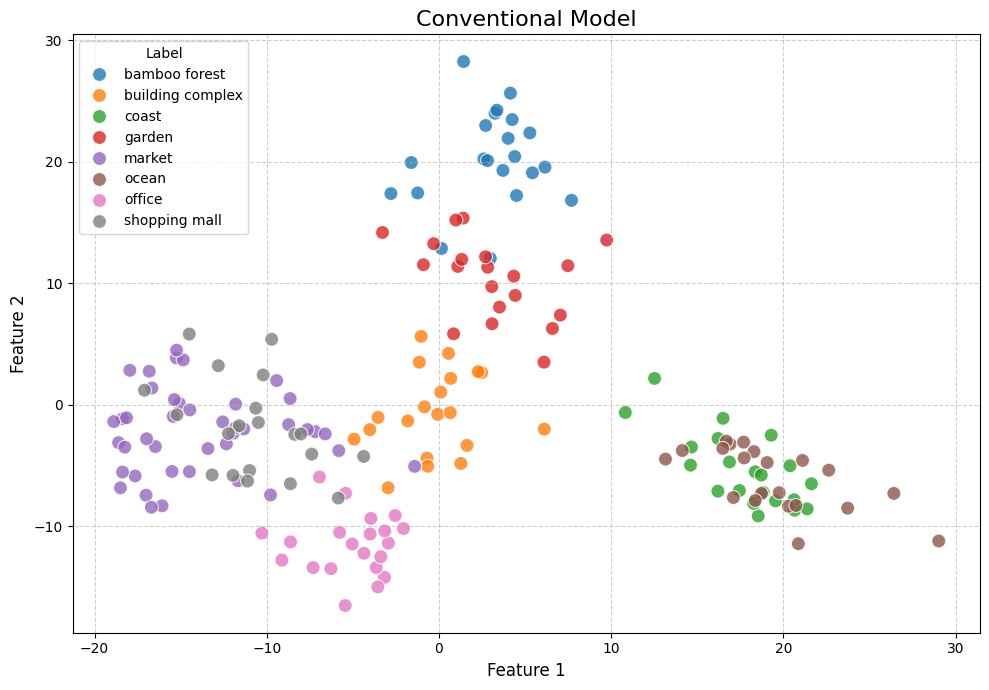

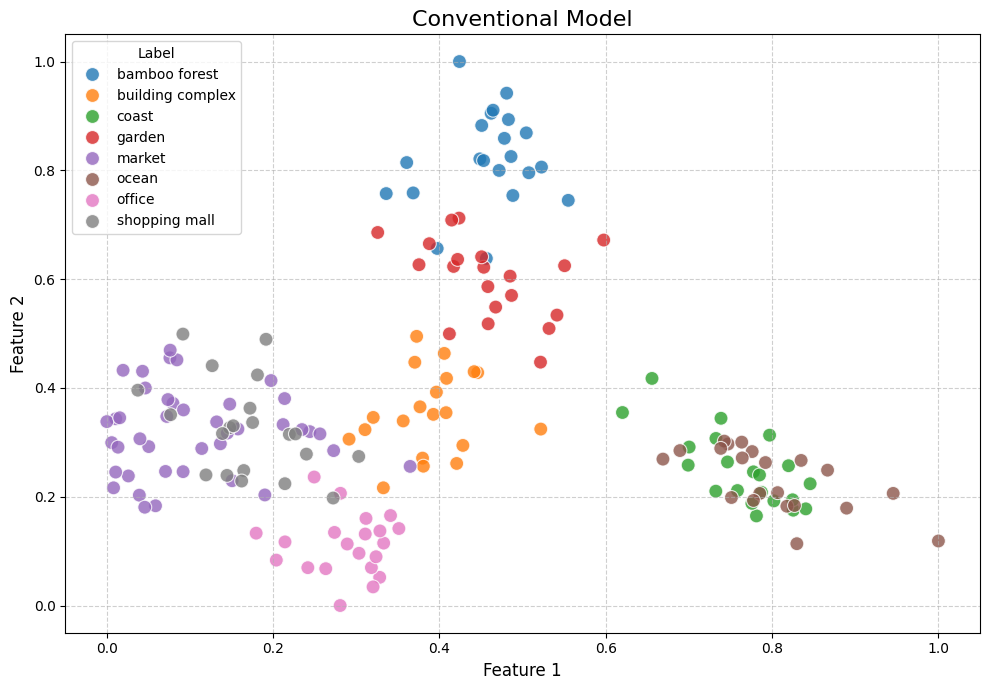

In [7]:
def plot_pca(dataframe, x_lable, y_lable, class_hue_lable, palette='tab20', graph_color=None, multi_cluster=True,
             graph_title='2D Scatter Plot', graph_xlabel='X', graph_ylabel='Y'):

    plt.figure(figsize=(10, 7))
    if graph_color == None:
        if multi_cluster:
            sns.scatterplot(data=dataframe, x=x_lable, y=y_lable, hue=class_hue_lable, 
                            palette=palette, s=100, alpha=0.8)
        else:
            sns.scatterplot(data=dataframe, x=x_lable, y=y_lable, hue=class_hue_lable, 
                            palette=palette, s=100, alpha=0.8)
            # Set x and y axis limits from 0 to 1
            plt.xlim(-0.1, 1.1)
            plt.ylim(-0.1, 1.1)
    else:
        sns.scatterplot(data=dataframe, x=x_lable, y=y_lable, color=graph_color, 
                        palette=palette, s=100, alpha=0.8)
        # Set x and y axis limits from 0 to 1
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)

    plt.title(graph_title, fontsize=16)
    plt.xlabel(graph_xlabel, fontsize=12)
    plt.ylabel(graph_ylabel, fontsize=12)
    plt.legend(title='Label', loc='upper left') # bbox_to_anchor=(1.05, 1), : Put the legend outside the plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot PCA
plot_pca(df_pca, 'PCA1', 'PCA2', 'class_labels', palette='tab10', 
         graph_title='Conventional Model', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_pca(scaled_df, 'PCA1', 'PCA2', 'class_labels', palette='tab10', 
         graph_title='Conventional Model', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')


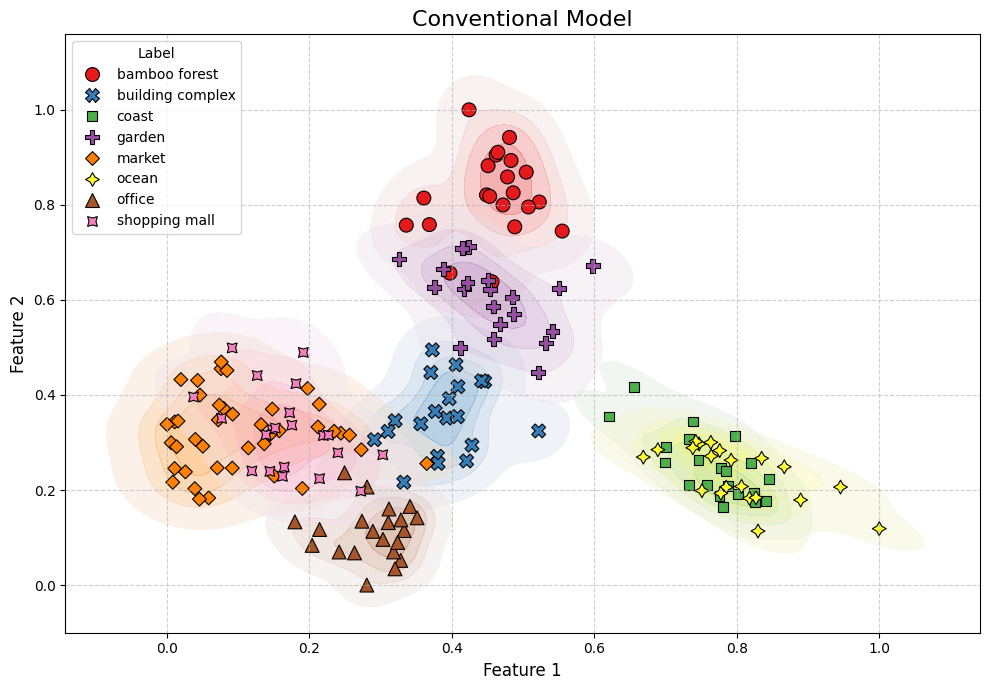

In [8]:
def plot_2d_scatter_with_hue_background(df, x_col, y_col, class_label_col, 
                                        graph_title='2D Scatter Plot', graph_xlabel='X', graph_ylabel='Y'):
    """
    Plots a 2D scatter plot with a soft KDE background for each class label.

    :param df: Pandas DataFrame
    :param x_col: Column name for X-axis
    :param y_col: Column name for Y-axis
    :param class_label_col: Column name containing class labels (used for hue)
    """
    plt.figure(figsize=(10, 7))
    
    unique_labels = df[class_label_col].unique()
    colors = sns.color_palette("Set1", len(unique_labels))

    # Plot KDE background for each class
    for label, color in zip(unique_labels, colors):
        subset = df[df[class_label_col] == label]
        if len(subset) > 1:  # KDE needs more than one point
            sns.kdeplot(x=subset[x_col], y=subset[y_col], cmap=sns.light_palette(color, as_cmap=True),
                        fill=True, alpha=0.4, levels=5, thresh=0.05)

    # Scatter plot with hue
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=class_label_col, style=class_label_col,
                    palette="Set1", s=100, edgecolor='black')

    plt.title(graph_title, fontsize=16)
    plt.xlabel(graph_xlabel, fontsize=12)
    plt.ylabel(graph_ylabel, fontsize=12)
    plt.legend(title='Label', loc='upper left') # bbox_to_anchor=(1.05, 1), : Put the legend outside the plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Call the function
plot_2d_scatter_with_hue_background(scaled_df, 'PCA1', 'PCA2', 'class_labels', 
                                    graph_title='Conventional Model', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')


In [9]:
# Convert features to numpy array
features = scaled_df.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [10]:
scaled_df['y_pred_clusters'] = y_pred_clusters
scaled_df.head()

,PCA1,PCA2,class_labels,y_pred_clusters
0,0.368336,0.758444,bamboo forest,1
1,0.424022,1.000000,bamboo forest,1
2,0.397236,0.656413,bamboo forest,1
3,0.488248,0.753731,bamboo forest,1
4,0.482927,0.893362,bamboo forest,1


In [11]:
# plot_pca(scaled_df, 'PCA1', 'PCA2', 'y_pred_clusters', palette='tab10')

In [12]:
# Group by Class and Cluster and count the occurrences
grouped = scaled_df.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
bamboo forest,0,21,1
building complex,11,9,0
coast,0,21,1
garden,0,20,1
market,41,0,0
ocean,0,21,1
office,21,0,0
shopping mall,21,0,0


In [13]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
# cluster_0_classes = grouped[grouped['finalCluster'] == 0]['class_labels'].tolist()
# cluster_1_classes = grouped[grouped['finalCluster'] == 1]['class_labels'].tolist()
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['building complex', 'market', 'office', 'shopping mall'] 

Classes in Cluster 1:  ['bamboo forest', 'coast', 'garden', 'ocean']


In [14]:
scaled_df['cluster'] = scaled_df['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
scaled_df

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.368336,0.758444,bamboo forest,1,1
1,0.424022,1.000000,bamboo forest,1,1
2,0.397236,0.656413,bamboo forest,1,1
3,0.488248,0.753731,bamboo forest,1,1
4,0.482927,0.893362,bamboo forest,1,1
...,...,...,...,...,...
181,0.239962,0.278348,shopping mall,0,0
182,0.164665,0.248183,shopping mall,0,0
183,0.091474,0.498982,shopping mall,0,0
184,0.162115,0.228826,shopping mall,0,0


#### 4-4 ---> Hierarchy Level 0 - Model 1

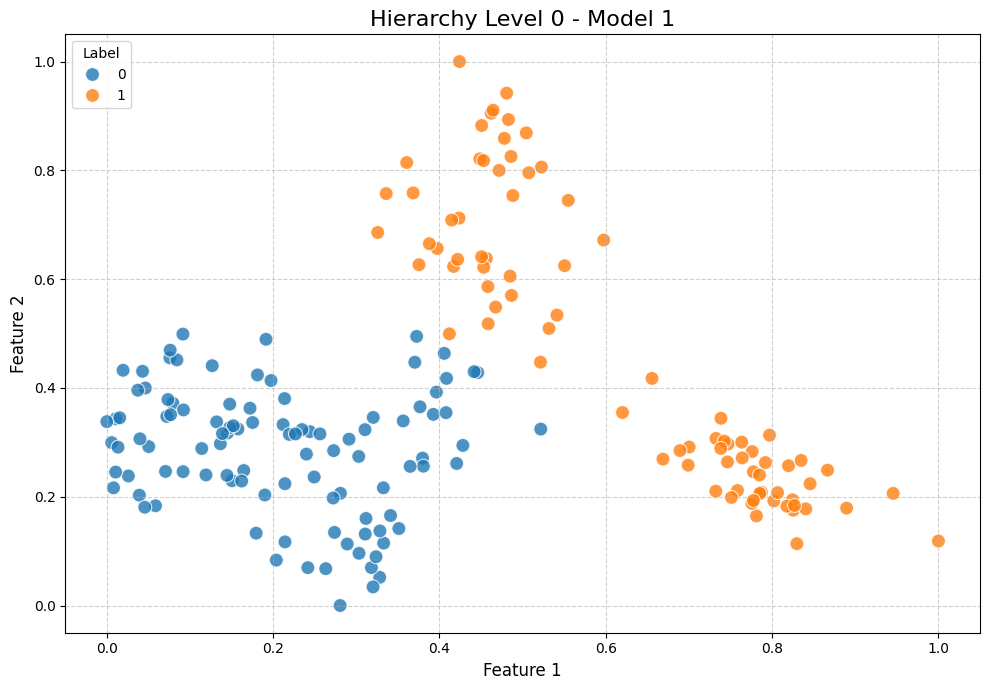

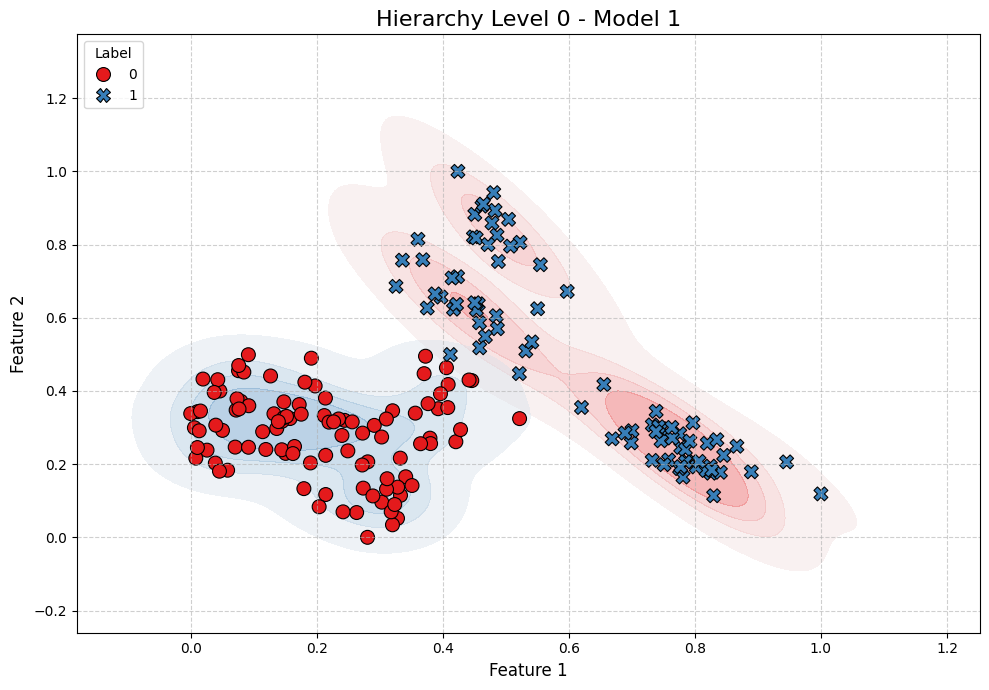

In [15]:
plot_pca(scaled_df, 'PCA1', 'PCA2', 'cluster', palette='tab10',
         graph_title='Hierarchy Level 0 - Model 1', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(scaled_df, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 0 - Model 1', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [16]:

data = pd.read_csv(CSV_PATH)
# X = data.iloc[:,:2048]  
# y = data[['class_labels']] 

data_c0 = data[data['class_labels'].isin(cluster_0_classes)]
data_c1 = data[data['class_labels'].isin(cluster_1_classes)]

data_c0.to_csv(c0_file_path, index=False)
data_c1.to_csv(c1_file_path, index=False)

data_c0 = pd.read_csv(c0_file_path)
data_c1 = pd.read_csv(c1_file_path)

print(f"{data.shape} \n{data_c0.shape} \n{data_c1.shape}")


(186, 2051) 
(103, 2051) 
(83, 2051)


In [17]:
# data = pd.read_csv(CSV_PATH)
# X = data.iloc[:,:2048]  
# y = data[['class_labels']] 

data_PCA_c0 = scaled_df[scaled_df['class_labels'].isin(cluster_0_classes)]
data_PCA_c1 = scaled_df[scaled_df['class_labels'].isin(cluster_1_classes)]

data_PCA_c0.to_csv(PCA_c0_file_path, index=False)
data_PCA_c1.to_csv(PCA_c1_file_path, index=False)

data_PCA_c0 = pd.read_csv(PCA_c0_file_path)
data_PCA_c1 = pd.read_csv(PCA_c1_file_path)

print(f"{scaled_df.shape} \n{data_PCA_c0.shape} \n{data_PCA_c1.shape}")


(186, 5) 
(103, 5) 
(83, 5)


In [18]:
data_PCA_c0.head(2)

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.379636,0.270969,building complex,0,0
1,0.408481,0.417568,building complex,1,0


In [19]:
data_PCA_c1.head(2)

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.368336,0.758444,bamboo forest,1,1
1,0.424022,1.000000,bamboo forest,1,1


In [20]:
# plot_pca(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', graph_color='blue', graph_title='Level 1 - Left side')

# plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', graph_color='orange', graph_title='Level 1 - Right side')

# plot_2d_scatter_with_hue_background(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', graph_title='Level 1 - Left side')

# plot_2d_scatter_with_hue_background(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', graph_title='Level 1 - Right side')

In [21]:
# data_PCA_c0, data_PCA_c1

# Convert features to numpy array
features = data_PCA_c0.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model_left_PCA_c0.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model_left_PCA_c0.pkl
Model loaded from ..\Models\kmean_model_left_PCA_c0.pkl
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]


In [22]:
data_PCA_c0['y_pred_clusters'] = y_pred_clusters
data_PCA_c0.head()

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.379636,0.270969,building complex,1,0
1,0.408481,0.417568,building complex,1,0
2,0.392633,0.351403,building complex,1,0
3,0.380607,0.256129,building complex,1,0
4,0.370339,0.447211,building complex,1,0


In [23]:
# plot_pca(data_PCA_c0, 'PCA1', 'PCA2', 'y_pred_clusters', multi_cluster=False, 
#          palette='tab10', graph_title='Hierarchy Level 1 - Model 2')

# plot_2d_scatter_with_hue_background(data_PCA_c0, 'PCA1', 'PCA2', 'y_pred_clusters', 
#                                     graph_title='Hierarchy Level 1 - Model 2')

# # plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'y_pred_clusters', multi_cluster=False, 
# #          palette='tab10', graph_title='Level 2 - Right side')

In [24]:
# Group by Class and Cluster and count the occurrences
grouped = data_PCA_c0.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
building complex,0,20,1
market,35,6,0
office,0,21,1
shopping mall,16,5,0


In [25]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Level 2_Left side_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['market', 'shopping mall'] 

Classes in Cluster 1:  ['building complex', 'office']


In [26]:
data_PCA_c0['cluster'] = data_PCA_c0['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_PCA_c0

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.379636,0.270969,building complex,1,1
1,0.408481,0.417568,building complex,1,1
2,0.392633,0.351403,building complex,1,1
3,0.380607,0.256129,building complex,1,1
4,0.370339,0.447211,building complex,1,1
...,...,...,...,...,...
98,0.239962,0.278348,shopping mall,1,0
99,0.164665,0.248183,shopping mall,0,0
100,0.091474,0.498982,shopping mall,0,0
101,0.162115,0.228826,shopping mall,0,0


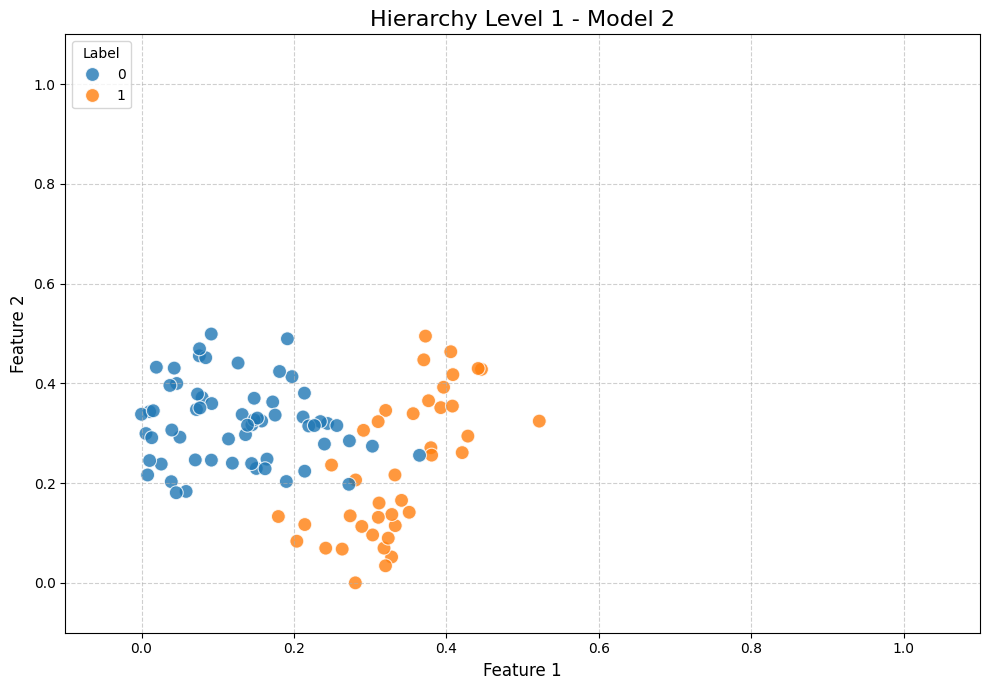

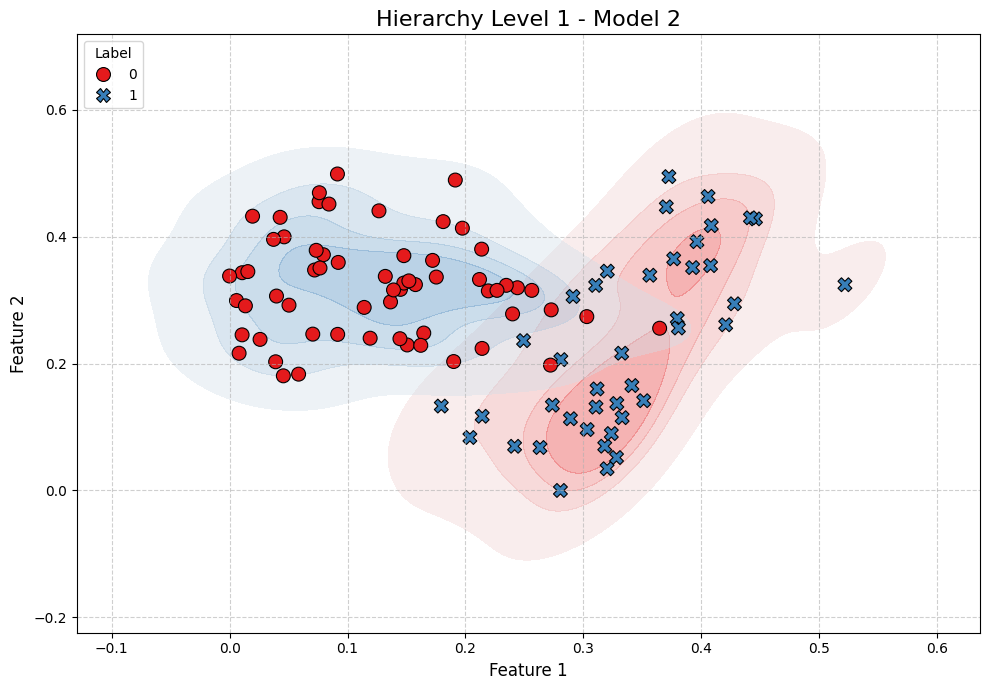

In [27]:
plot_pca(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 1 - Model 2', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 1 - Model 2', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [28]:
data_PCA_c0

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.379636,0.270969,building complex,1,1
1,0.408481,0.417568,building complex,1,1
2,0.392633,0.351403,building complex,1,1
3,0.380607,0.256129,building complex,1,1
4,0.370339,0.447211,building complex,1,1
...,...,...,...,...,...
98,0.239962,0.278348,shopping mall,1,0
99,0.164665,0.248183,shopping mall,0,0
100,0.091474,0.498982,shopping mall,0,0
101,0.162115,0.228826,shopping mall,0,0


In [29]:
cluster_0_classes, cluster_1_classes

(['market', 'shopping mall'], ['building complex', 'office'])

In [30]:
Left_side_PCA_c0_file_path = os.path.join('..', 'Dataset', 'Left_side_PCA_C0_features.csv')
Left_side_PCA_c1_file_path = os.path.join('..', 'Dataset', 'Left_side_PCA_C1_features.csv')

data_Left_side_PCA_c0 = data_PCA_c0[data_PCA_c0['class_labels'].isin(cluster_0_classes)]
data_Left_side_PCA_c1 = data_PCA_c0[data_PCA_c0['class_labels'].isin(cluster_1_classes)]

data_Left_side_PCA_c0.to_csv(Left_side_PCA_c0_file_path, index=False)
data_Left_side_PCA_c1.to_csv(Left_side_PCA_c1_file_path, index=False)

data_Left_side_PCA_c0 = pd.read_csv(Left_side_PCA_c0_file_path)
data_Left_side_PCA_c1 = pd.read_csv(Left_side_PCA_c1_file_path)

print(f"{data_PCA_c0.shape} \n{data_Left_side_PCA_c0.shape} \n{data_Left_side_PCA_c1.shape}")


(103, 5) 
(62, 5) 
(41, 5)


#### 2-2

In [31]:
# data_Left_side_PCA_c0, data_Left_side_PCA_c1

# Convert features to numpy array
features = data_Left_side_PCA_c0.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0]


In [32]:
data_Left_side_PCA_c0['y_pred_clusters'] = y_pred_clusters
data_Left_side_PCA_c0.head()

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.136480,0.297256,market,0,0
1,0.197408,0.413551,market,0,0
2,0.147787,0.370202,market,0,0
3,0.079531,0.371657,market,1,0
4,0.364694,0.255762,market,0,0


In [33]:
# Group by Class and Cluster and count the occurrences
grouped = data_Left_side_PCA_c0.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
market,15,26,1
shopping mall,17,4,0


In [34]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Left_side_PCA_c0_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['shopping mall'] 

Classes in Cluster 1:  ['market']


In [35]:
data_Left_side_PCA_c0['cluster'] = data_Left_side_PCA_c0['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Left_side_PCA_c0

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.136480,0.297256,market,0,1
1,0.197408,0.413551,market,0,1
2,0.147787,0.370202,market,0,1
3,0.079531,0.371657,market,1,1
4,0.364694,0.255762,market,0,1
...,...,...,...,...,...
57,0.239962,0.278348,shopping mall,0,0
58,0.164665,0.248183,shopping mall,0,0
59,0.091474,0.498982,shopping mall,1,0
60,0.162115,0.228826,shopping mall,0,0


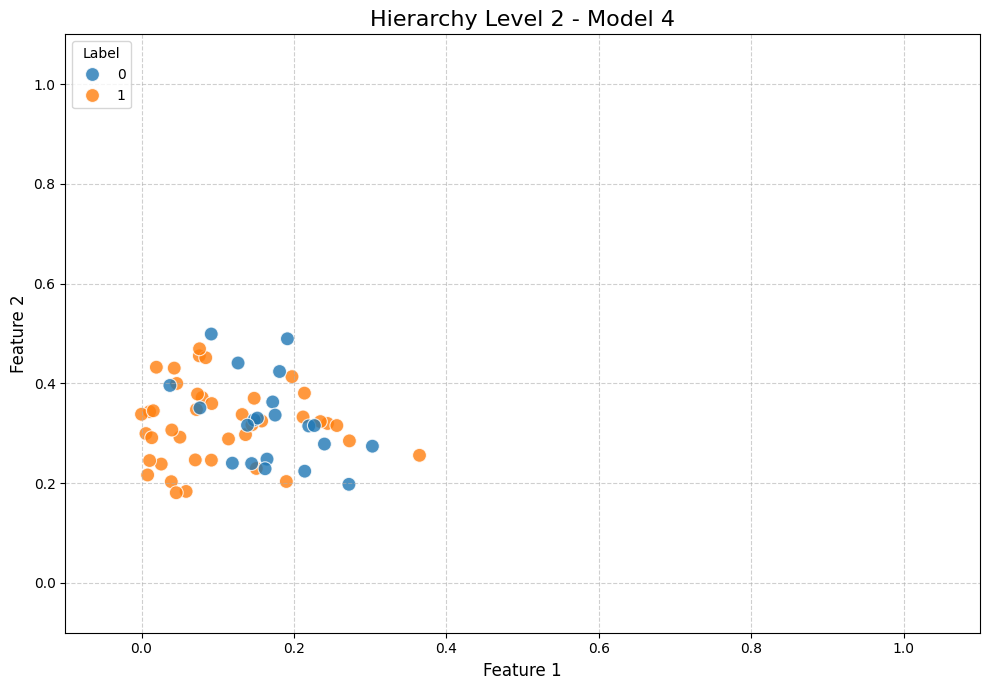

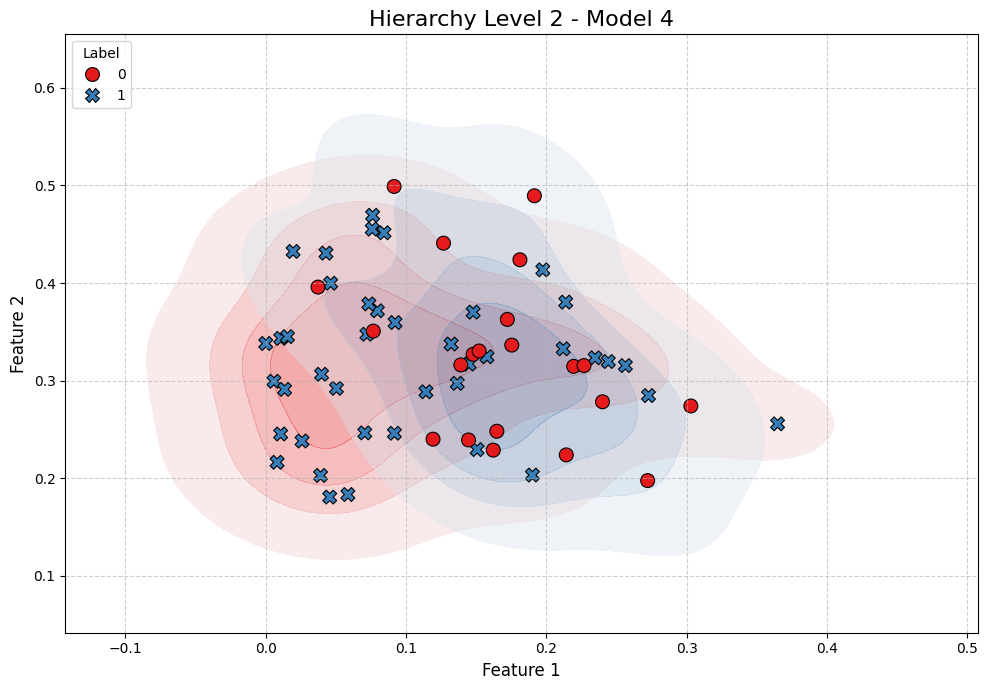

In [36]:
plot_pca(data_Left_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 4', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Left_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 4', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

### Hierarchy Level 2 - Model 5

In [37]:
# data_Left_side_PCA_c0, data_Left_side_PCA_c1

# Convert features to numpy array
features = data_Left_side_PCA_c1.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [38]:
data_Left_side_PCA_c1['y_pred_clusters'] = y_pred_clusters
data_Left_side_PCA_c1.head()

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.379636,0.270969,building complex,1,1
1,0.408481,0.417568,building complex,1,1
2,0.392633,0.351403,building complex,1,1
3,0.380607,0.256129,building complex,1,1
4,0.370339,0.447211,building complex,1,1


In [39]:
# Group by Class and Cluster and count the occurrences
grouped = data_Left_side_PCA_c1.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
building complex,1,19,1
office,21,0,0


In [40]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Left_side_PCA_c1_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['office'] 

Classes in Cluster 1:  ['building complex']


In [41]:
data_Left_side_PCA_c1['cluster'] = data_Left_side_PCA_c1['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Left_side_PCA_c1

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.379636,0.270969,building complex,1,1
1,0.408481,0.417568,building complex,1,1
2,0.392633,0.351403,building complex,1,1
3,0.380607,0.256129,building complex,1,1
4,0.370339,0.447211,building complex,1,1
5,0.420692,0.261166,building complex,1,1
6,0.372548,0.494831,building complex,1,1
7,0.291245,0.305860,building complex,1,1
8,0.445984,0.428214,building complex,1,1
9,0.332501,0.216379,building complex,0,1


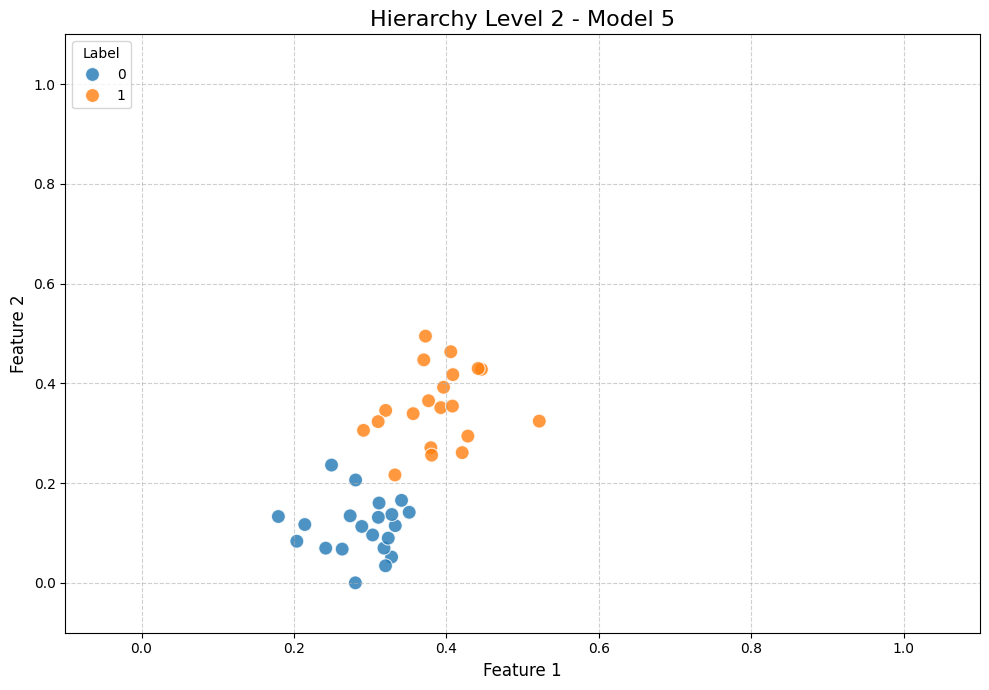

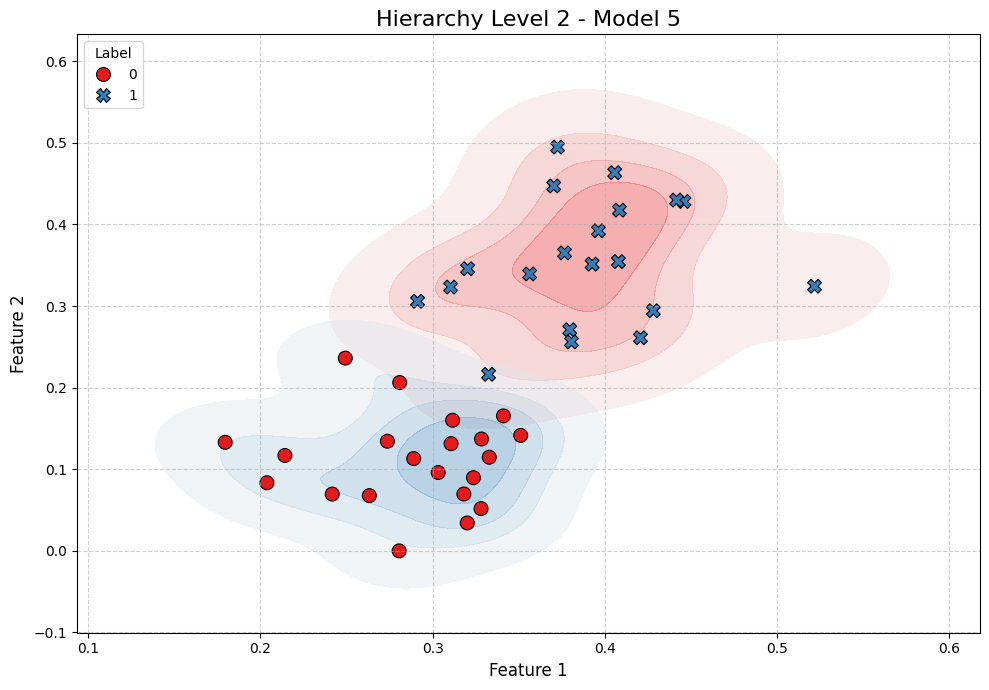

In [42]:
plot_pca(data_Left_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 5', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Left_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 5', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

## Right branch

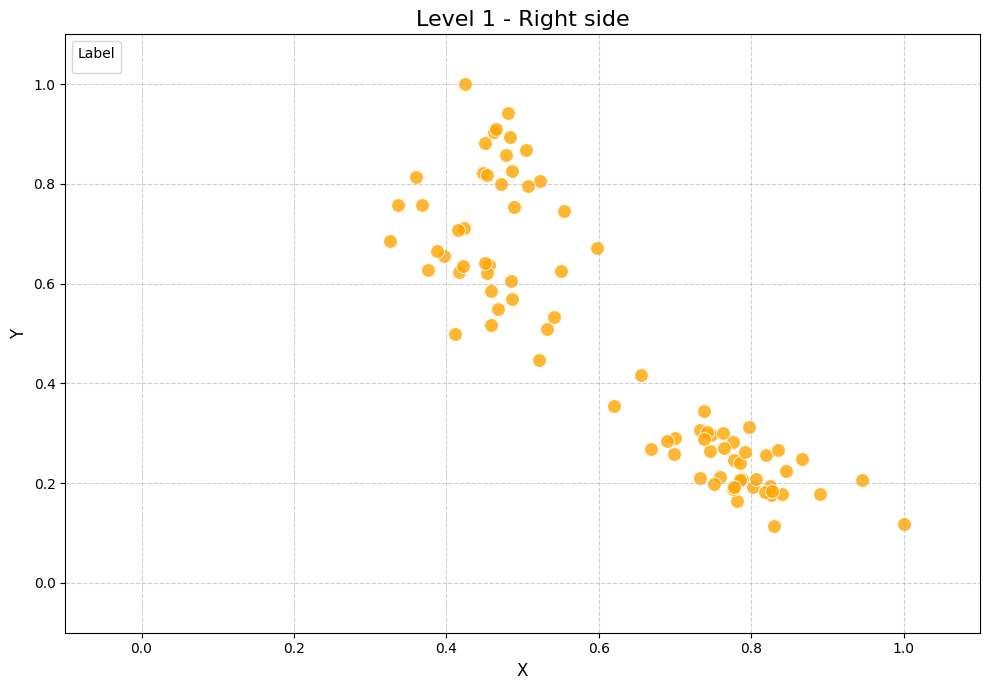

In [43]:
plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', graph_color='orange', graph_title='Level 1 - Right side')

In [44]:
# data_PCA_c1

# Convert features to numpy array
features = data_PCA_c1.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [45]:
data_PCA_c1['y_pred_clusters'] = y_pred_clusters
data_PCA_c1.head()

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.368336,0.758444,bamboo forest,1,1
1,0.424022,1.000000,bamboo forest,1,1
2,0.397236,0.656413,bamboo forest,1,1
3,0.488248,0.753731,bamboo forest,1,1
4,0.482927,0.893362,bamboo forest,1,1


In [46]:
# Group by Class and Cluster and count the occurrences
grouped = data_PCA_c1.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
bamboo forest,0,21,1
coast,21,0,0
garden,0,20,1
ocean,21,0,0


In [47]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Right_side_PCA_c1_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['coast', 'ocean'] 

Classes in Cluster 1:  ['bamboo forest', 'garden']


In [48]:
data_PCA_c1['cluster'] = data_PCA_c1['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_PCA_c1

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.368336,0.758444,bamboo forest,1,1
1,0.424022,1.000000,bamboo forest,1,1
2,0.397236,0.656413,bamboo forest,1,1
3,0.488248,0.753731,bamboo forest,1,1
4,0.482927,0.893362,bamboo forest,1,1
...,...,...,...,...,...
78,0.889594,0.179039,ocean,0,0
79,0.763489,0.300351,ocean,0,0
80,0.777596,0.193127,ocean,0,0
81,0.792006,0.262824,ocean,0,0


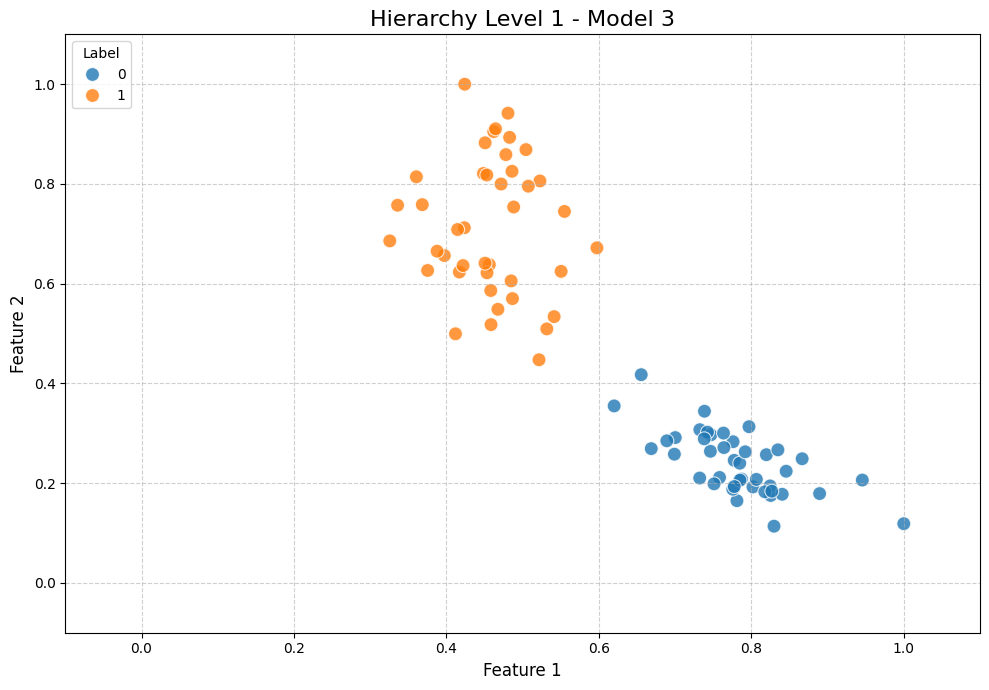

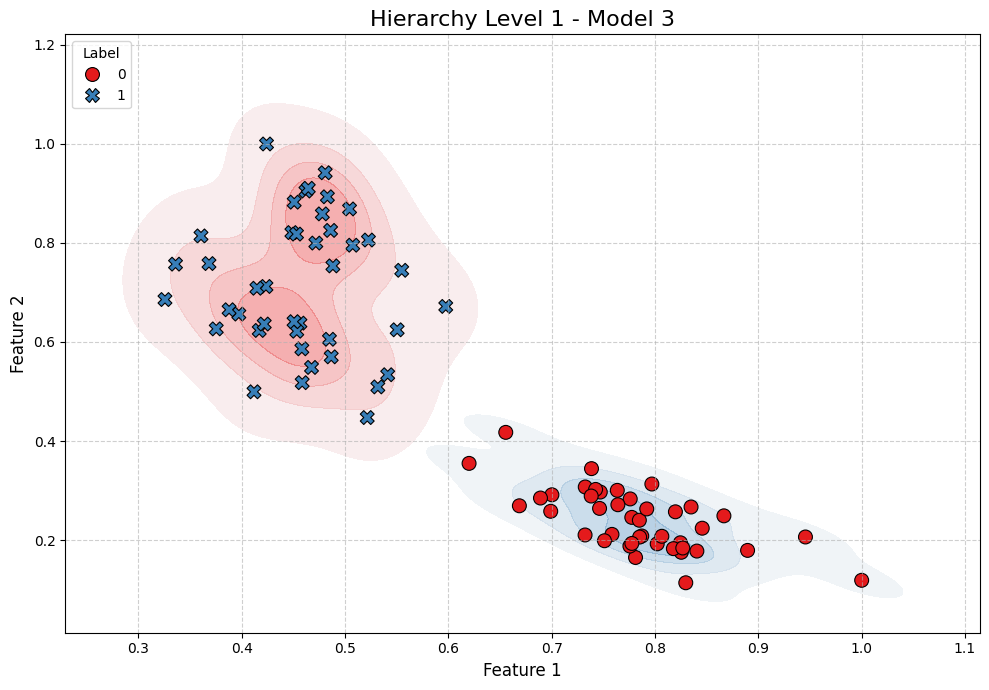

In [49]:
plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 1 - Model 3', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 1 - Model 3', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [50]:
Right_side_PCA_c0_file_path = os.path.join('..', 'Dataset', 'Right_side_PCA_C0_features.csv')
Right_side_PCA_c1_file_path = os.path.join('..', 'Dataset', 'Right_side_PCA_C1_features.csv')

data_Right_side_PCA_c0 = data_PCA_c1[data_PCA_c1['class_labels'].isin(cluster_0_classes)]
data_Right_side_PCA_c1 = data_PCA_c1[data_PCA_c1['class_labels'].isin(cluster_1_classes)]

data_Right_side_PCA_c0.to_csv(Right_side_PCA_c0_file_path, index=False)
data_Right_side_PCA_c1.to_csv(Right_side_PCA_c1_file_path, index=False)

data_Right_side_PCA_c0 = pd.read_csv(Right_side_PCA_c0_file_path)
data_Right_side_PCA_c1 = pd.read_csv(Right_side_PCA_c1_file_path)

print(f"{data_PCA_c1.shape} \n{data_Right_side_PCA_c0.shape} \n{data_Right_side_PCA_c1.shape}")


(83, 5) 
(42, 5) 
(41, 5)


In [51]:
# data_Right_side_PCA_c0

# Convert features to numpy array
features = data_Right_side_PCA_c0.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0
 0 1 0 0 0]


In [52]:
data_Right_side_PCA_c0['y_pred_clusters'] = y_pred_clusters
data_Right_side_PCA_c0.head()

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.699064,0.258063,coast,1,0
1,0.746336,0.263879,coast,1,0
2,0.732487,0.307146,coast,1,0
3,0.787191,0.208120,coast,0,0
4,0.777540,0.245718,coast,0,0


In [53]:
# Group by Class and Cluster and count the occurrences
grouped = data_Right_side_PCA_c0.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
coast,13,8,0
ocean,13,8,0


In [54]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Right_side_PCA_c0_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['coast', 'ocean'] 

Classes in Cluster 1:  []


In [55]:
data_Right_side_PCA_c0['cluster'] = data_Right_side_PCA_c0['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Right_side_PCA_c0

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.699064,0.258063,coast,1,0
1,0.746336,0.263879,coast,1,0
2,0.732487,0.307146,coast,1,0
3,0.787191,0.208120,coast,0,0
4,0.777540,0.245718,coast,0,0
5,0.825424,0.175238,coast,0,0
6,0.700212,0.291345,coast,1,0
7,0.655549,0.417471,coast,1,0
8,0.781147,0.164721,coast,0,0
9,0.775718,0.187837,coast,0,0


## Issue : As I told you - if we don't preprocessing part then this will happend

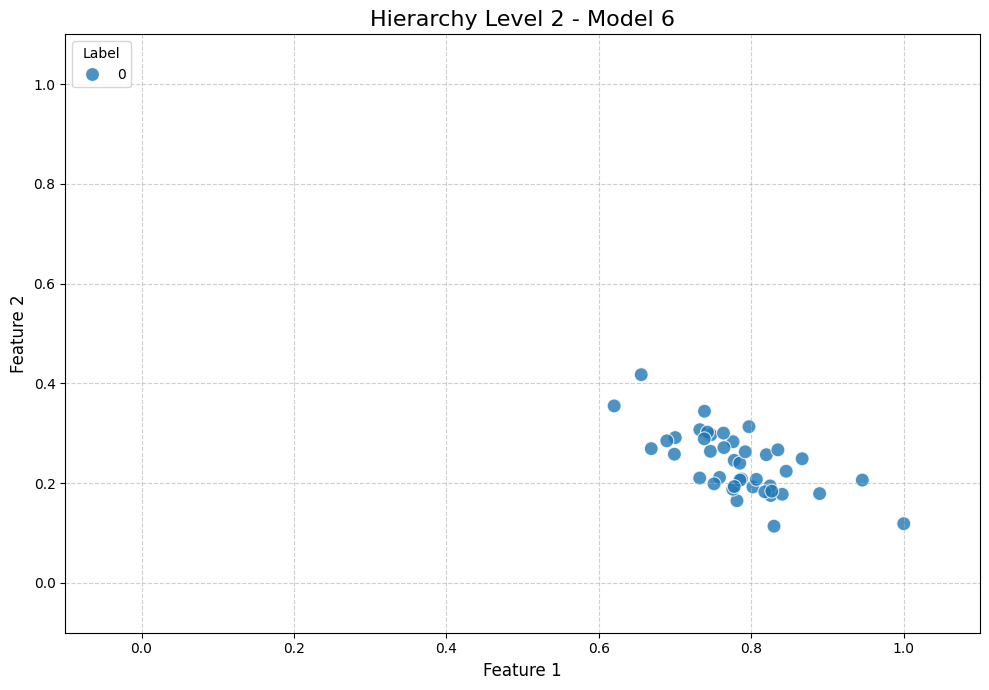

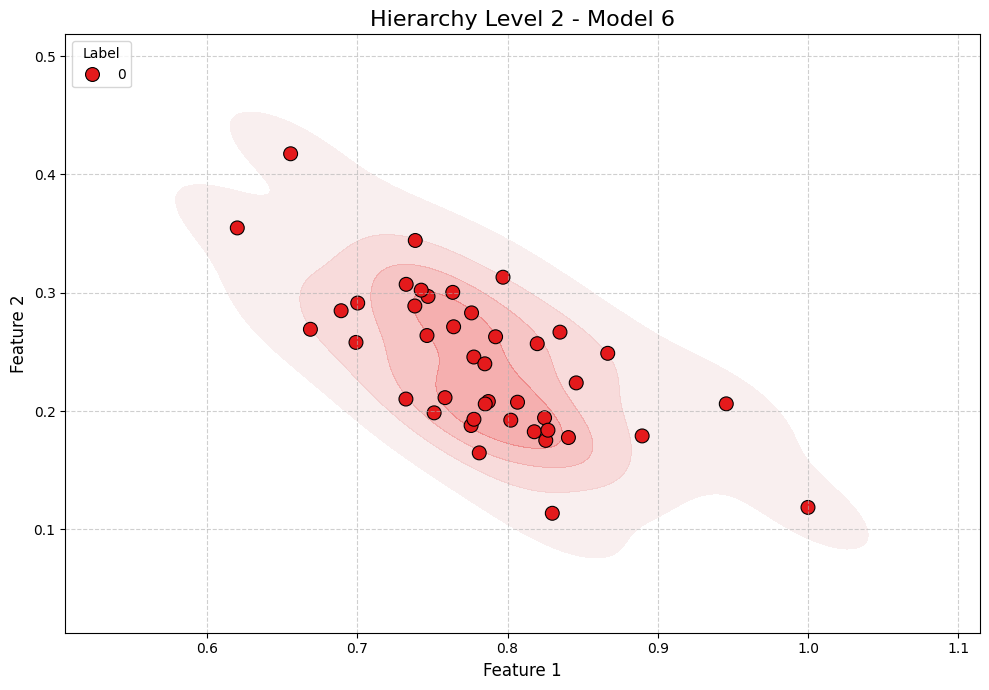

In [56]:
plot_pca(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 6', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 6', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

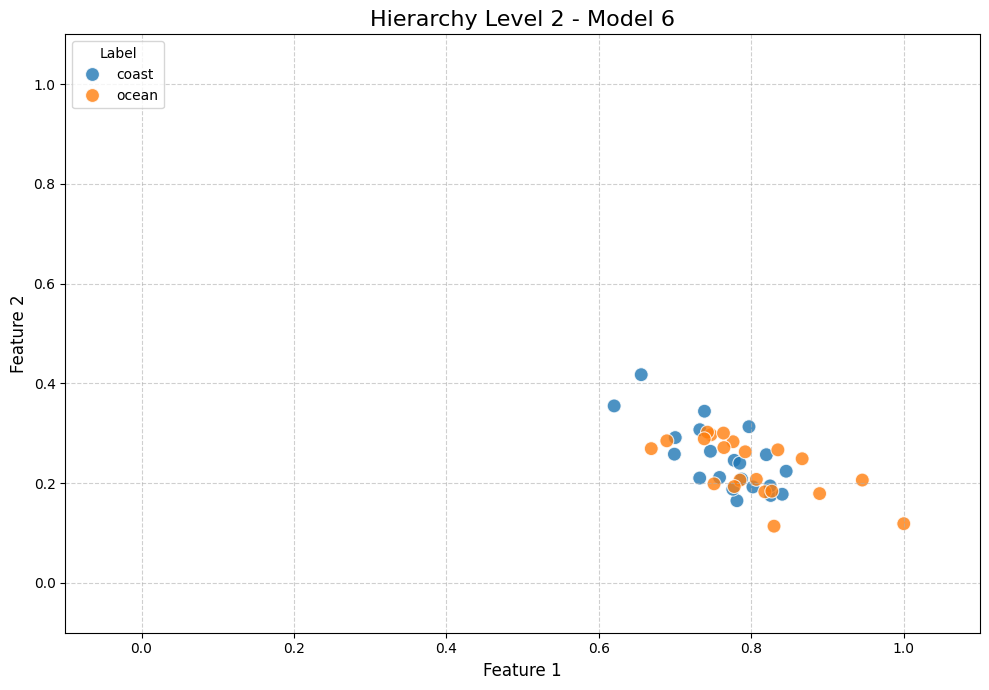

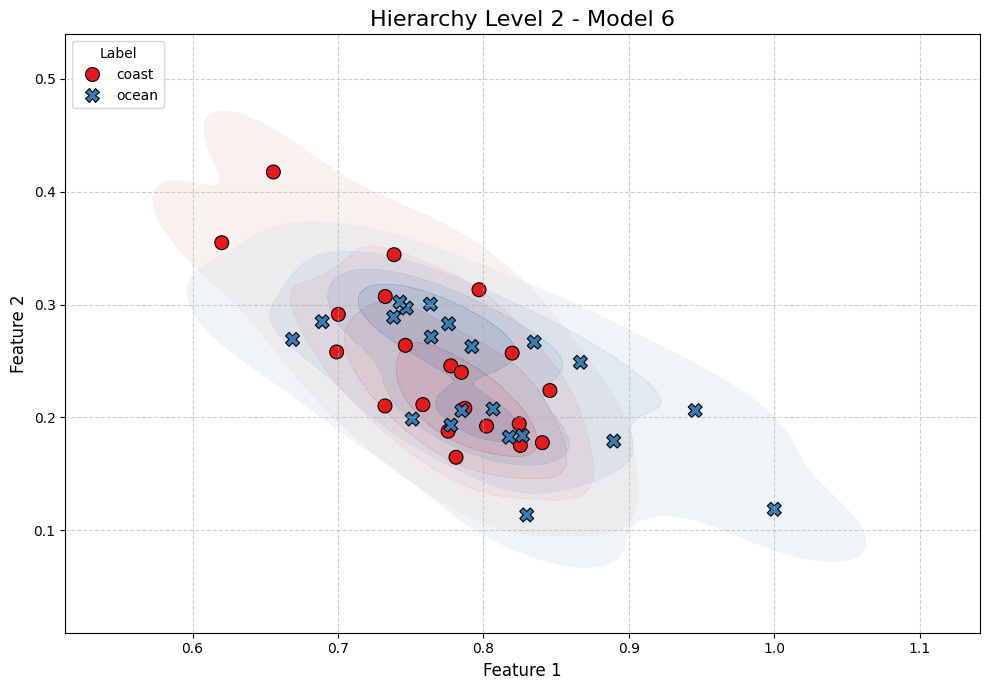

In [57]:
plot_pca(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'class_labels', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 6', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'class_labels', 
                                    graph_title='Hierarchy Level 2 - Model 6', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

## Jugad

In [58]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder and create new column 'cluster1'
data_Right_side_PCA_c0['cluster1'] = label_encoder.fit_transform(data_Right_side_PCA_c0['class_labels'])

# Display the DataFrame
data_Right_side_PCA_c0


,PCA1,PCA2,class_labels,y_pred_clusters,cluster,cluster1
0,0.699064,0.258063,coast,1,0,0
1,0.746336,0.263879,coast,1,0,0
2,0.732487,0.307146,coast,1,0,0
3,0.787191,0.208120,coast,0,0,0
4,0.777540,0.245718,coast,0,0,0
5,0.825424,0.175238,coast,0,0,0
6,0.700212,0.291345,coast,1,0,0
7,0.655549,0.417471,coast,1,0,0
8,0.781147,0.164721,coast,0,0,0
9,0.775718,0.187837,coast,0,0,0


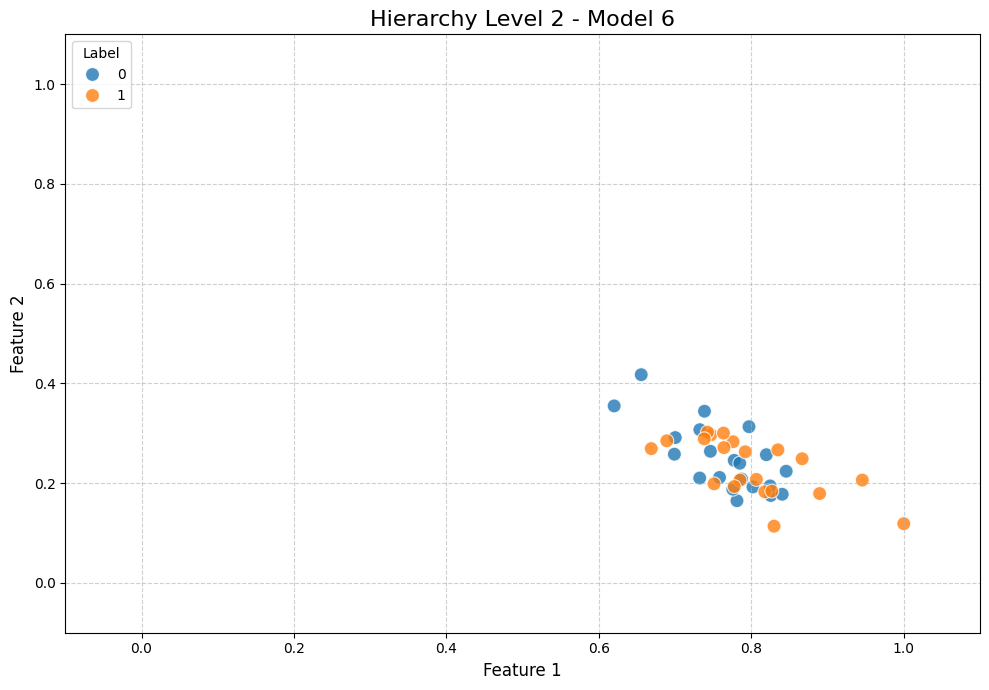

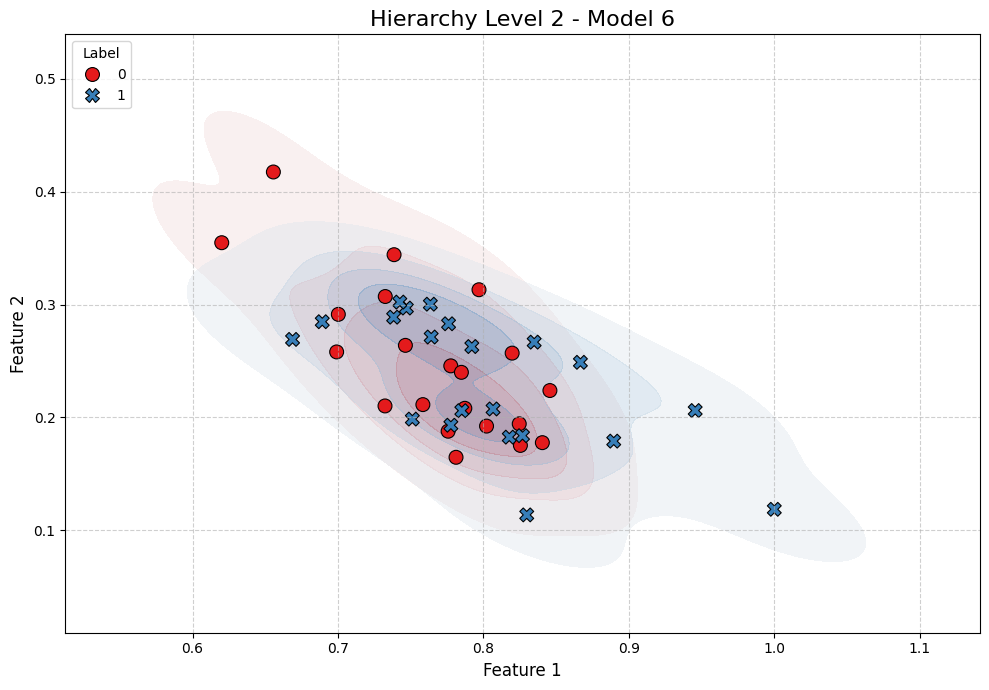

In [59]:
plot_pca(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster1', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 6', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster1', 
                                    graph_title='Hierarchy Level 2 - Model 6', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [60]:
# data_Right_side_PCA_c1

# Convert features to numpy array
features = data_Right_side_PCA_c1.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [61]:
data_Right_side_PCA_c1['y_pred_clusters'] = y_pred_clusters
data_Right_side_PCA_c1.head()

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.368336,0.758444,bamboo forest,1,1
1,0.424022,1.000000,bamboo forest,1,1
2,0.397236,0.656413,bamboo forest,0,1
3,0.488248,0.753731,bamboo forest,1,1
4,0.482927,0.893362,bamboo forest,1,1


In [62]:
# Group by Class and Cluster and count the occurrences
grouped = data_Right_side_PCA_c1.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters,0,1,finalCluster
class_labels,,,
bamboo forest,2,19,1
garden,20,0,0


In [63]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Right_side_PCA_c1_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['garden'] 

Classes in Cluster 1:  ['bamboo forest']


In [64]:
data_Right_side_PCA_c1['cluster'] = data_Right_side_PCA_c1['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Right_side_PCA_c1

,PCA1,PCA2,class_labels,y_pred_clusters,cluster
0,0.368336,0.758444,bamboo forest,1,1
1,0.424022,1.000000,bamboo forest,1,1
2,0.397236,0.656413,bamboo forest,0,1
3,0.488248,0.753731,bamboo forest,1,1
4,0.482927,0.893362,bamboo forest,1,1
5,0.450793,0.882462,bamboo forest,1,1
6,0.522665,0.805974,bamboo forest,1,1
7,0.480799,0.941846,bamboo forest,1,1
8,0.462134,0.904942,bamboo forest,1,1
9,0.456351,0.638094,bamboo forest,0,1


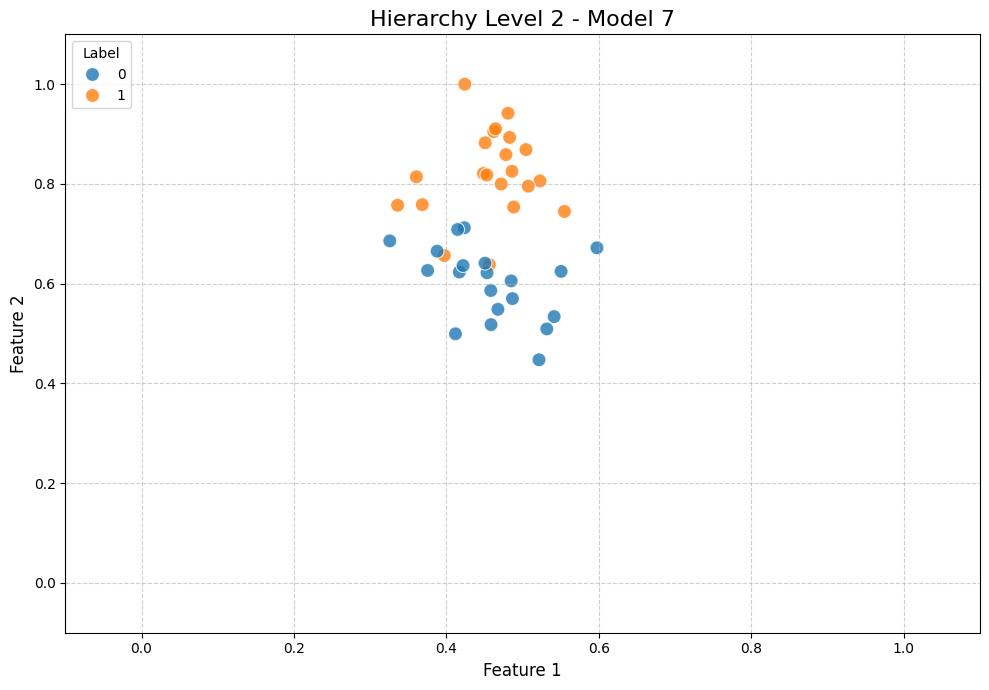

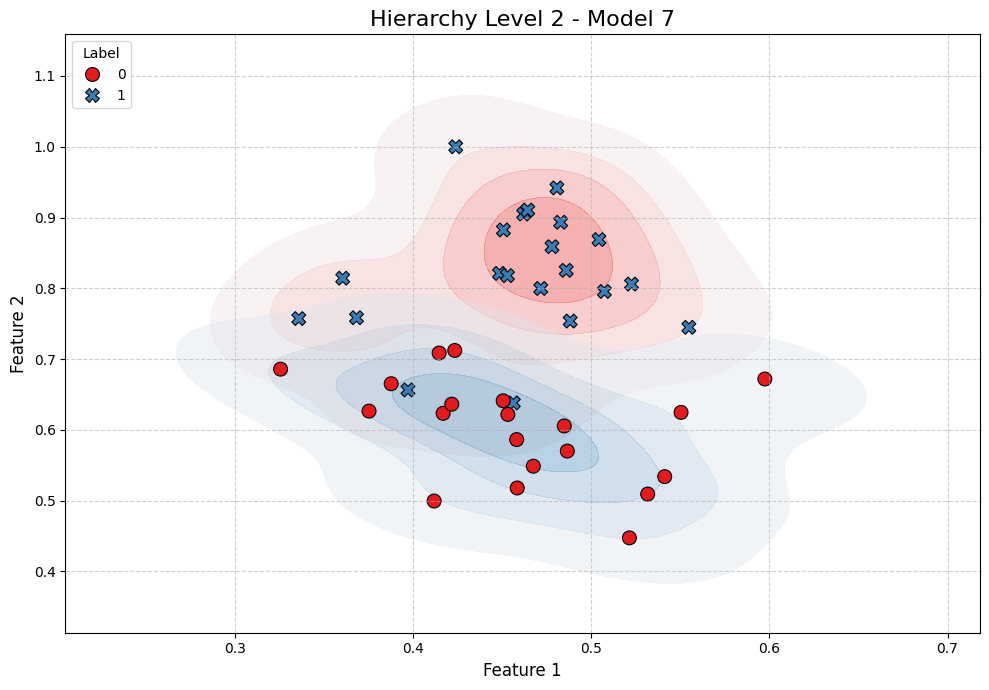

In [65]:
plot_pca(data_Right_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 7', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 7', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')